## Robust DET36A2 Photoresistor Trigger Extraction Process - Brief Summary

### Two-Stage Pipeline

**Stage 1: Initial Detection (Derivative Thresholding)**
1. Extract photoresistor signal from analog channel
2. Compute derivative, bin the signal into bins to increase SNR (`mean_n=10` samples), and z-score normalize
3. Test thresholds ~1-10 SD, visualize trigger counts vs. threshold. We look for a stable range in which the number of extracted triggers is roughly constant, indicating we are detecting essentially Delta functions
4. Select threshold ~6 SD

**Stage 2: Template Refinement (Cross-Correlation)**
1. Extract 100ms windows around initial triggers (-25ms to +75ms)
2. Average to create high-SNR template. This is the "stimulus response function" of the DET36A2 photoresistor in our setup.
3. Sliding-window cross-correlation across entire raw signal (z-scored)
4. Greedy peak extraction: find max correlation, suppress surrounding region, repeat
5. Filter by correlation > 0.8 threshold → **final extracted triggers**

### Key Robustness Features

1. **Dual Validation**: Threshold detection + template matching
4. **Template Averaging**: the initial stage extracts high-SNR canonical waveform
3. **Scale-Invariant**: Z-scoring handles signal drift, gain changes, baseline shifts
5. **Non-Overlapping Extraction**: Suppression windows prevent double-counting
7. **High Temporal Precision**: 10kHz sampling = +- 1ms final resolution at least

**Result**: All validated triggers saved to `triggers_DET36A2.npy` with sub-millisecond accuracy.

In [ ]:
# Run to install the necessary packages
# !pip install temporaldata neo

In [1]:
from neo.io import BlackrockIO
import os, glob

# Get all files ending with 'ccf' in current directory
session_name = os.path.splitext(glob.glob('*.ccf')[0])[0]
blackrock_io = BlackrockIO(filename=f'{session_name}-001.ns5')
blackrock_io.parse_header()

# Print channel names and sampling rate
# print("Channel names:", blackrock_io.header['signal_channels']['name'])
print("Sampling rate:", blackrock_io.header['signal_channels']['sampling_rate'][0], "Hz")

Sampling rate: 10000.0 Hz


In [2]:
blackrock_io = blackrock_io
analog_channel_index = 1 # which analog channel to use for trigger detection
mean_n = 10 # bin size in samples (necessary to increase signal-to-noise ratio)

sampling_rate = blackrock_io.header['signal_channels']['sampling_rate'][0]

channel_names = ["ainp" + str(analog_channel_index)]
raw_analog_signal = blackrock_io.get_analogsignal_chunk(block_index=0, seg_index=0, channel_names=channel_names)    # shape: (n_samples, 1)
raw_analog_signal = blackrock_io.rescale_signal_raw_to_float(raw_analog_signal, dtype='float64', channel_names=channel_names).flatten()     # shape: (n_samples, )
d_raw_analog_signal = raw_analog_signal[1:] - raw_analog_signal[:-1] # shape: (n_samples-1, )

mean_d_raw_analog_signal = d_raw_analog_signal[:(len(d_raw_analog_signal)//mean_n*mean_n)].reshape(-1, mean_n).mean(axis=1) # shape: (n_samples//mean_n, )
z_scored_mean_d_signal = (mean_d_raw_analog_signal - mean_d_raw_analog_signal.mean()) / mean_d_raw_analog_signal.std()
z_scored_mean_d_signal.shape

(501578,)

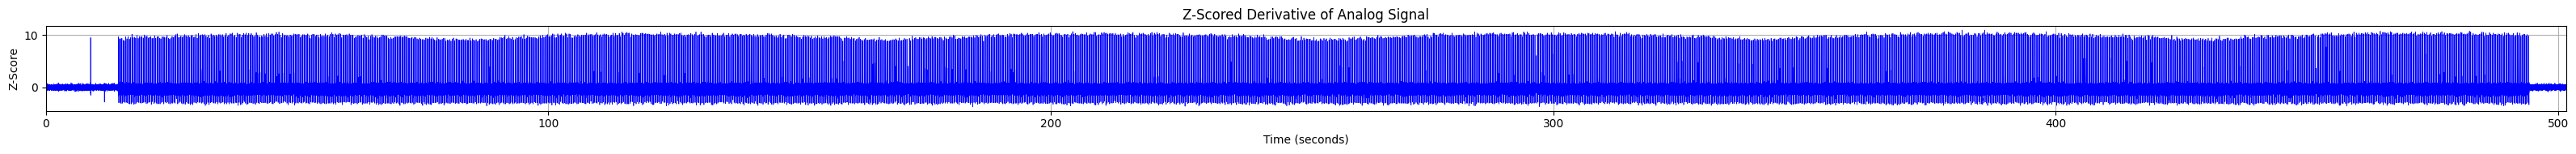

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 2))
time_axis = np.arange(len(z_scored_mean_d_signal)) * mean_n / sampling_rate
plt.plot(time_axis, z_scored_mean_d_signal, color='blue', linewidth=0.5)
plt.xlim(0, time_axis[-1])
plt.title('Z-Scored Derivative of Analog Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Z-Score')
plt.grid(True)
plt.tight_layout()
plt.show()

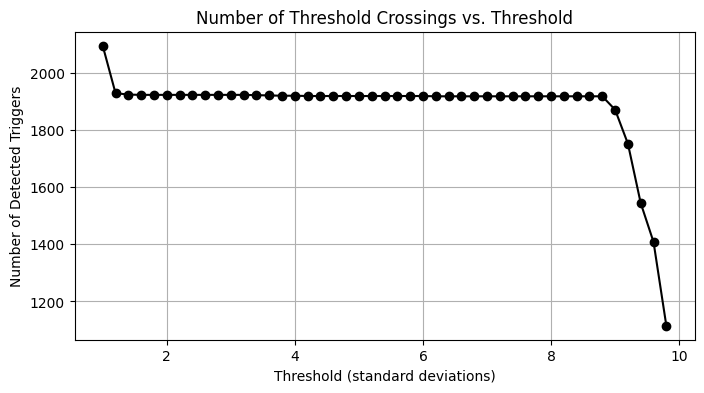

In [4]:
test_threshold_range_from = 1
test_threshold_range_to = 10
test_threshold_step = 0.2

thresholds = np.arange(test_threshold_range_from, test_threshold_range_to, test_threshold_step)
crossings_count = []
for threshold in thresholds:
    above_threshold = z_scored_mean_d_signal > threshold
    n_crossings = np.sum(np.logical_and(above_threshold[1:], ~above_threshold[:-1]))
    crossings_count.append(n_crossings)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, crossings_count, marker='o', color='black')
plt.title('Number of Threshold Crossings vs. Threshold')
plt.xlabel('Threshold (standard deviations)')
plt.ylabel('Number of Detected Triggers')
plt.grid(True)
plt.show()

In [5]:
threshold = 6
print("Using threshold of", threshold, "standard deviations")

# Get boolean array of threshold crossings
above_threshold = z_scored_mean_d_signal > threshold
# Find where signal first crosses threshold (rising edge)
n_crossings = np.sum(np.logical_and(above_threshold[1:], ~above_threshold[:-1]))
print(f"Number of detected triggers: {n_crossings}")

crossings = np.where(np.logical_and(above_threshold[1:], ~above_threshold[:-1]))[0]
crossing_samples = crossings * mean_n
crossing_seconds = crossing_samples / sampling_rate

Using threshold of 6 standard deviations
Number of detected triggers: 1919


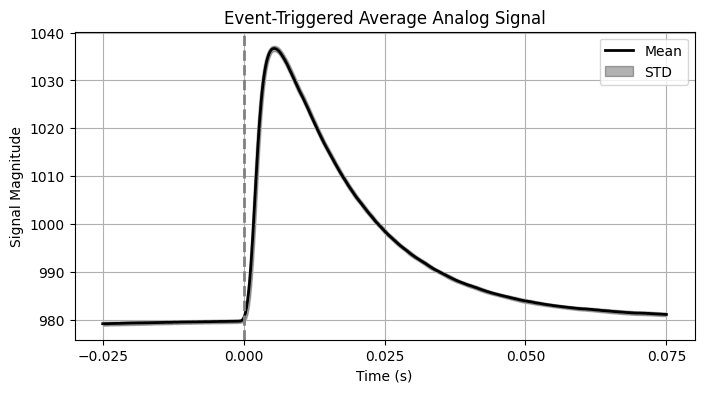

In [6]:
extract_kernel_from = -0.025
extract_kernel_to = 0.075

# Convert kernel times to sample indices
kernel_start_sample = int(extract_kernel_from * sampling_rate)
kernel_end_sample = int(extract_kernel_to * sampling_rate)

# Extract segments around each crossing
triggered_segments = []
for crossing in crossing_samples:
    start_idx = int(crossing) + kernel_start_sample
    end_idx = int(crossing) + kernel_end_sample
    segment = raw_analog_signal[start_idx:end_idx]
    if len(segment) == (kernel_end_sample - kernel_start_sample):  # Ensure full-length segments
        triggered_segments.append(segment)

triggered_segments = np.array(triggered_segments)

# Calculate mean and SEM
mean_triggered = triggered_segments.mean(axis=0)
std_triggered = triggered_segments.std(axis=0, ddof=1)
sem_triggered = std_triggered / np.sqrt(triggered_segments.shape[0])

# Create time axis for plotting
time_axis = np.linspace(extract_kernel_from, extract_kernel_to, mean_triggered.size)
x_ticks = list(np.arange(extract_kernel_from, extract_kernel_to, 0.025)) + [extract_kernel_to]

# Plot the mean and SEM
plt.figure(figsize=(8, 4))
plt.plot(time_axis, mean_triggered, label='Mean', color='black', linewidth=2)
plt.fill_between(time_axis, mean_triggered - std_triggered, mean_triggered + std_triggered, alpha=0.3, label='STD', color='black')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.xticks(x_ticks)
plt.title('Event-Triggered Average Analog Signal')
plt.xlabel('Time (s)')
plt.ylabel('Signal Magnitude')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from tqdm import tqdm
print("Calculating correlations...")

correlations = []
z_scored_mean_triggered = (mean_triggered - mean_triggered.mean()) / np.std(mean_triggered, ddof=1)
for i in tqdm(range(len(raw_analog_signal) - len(mean_triggered))):
    raw_signal_piece = raw_analog_signal[i:i+len(mean_triggered)]

    z_scored_raw_signal_piece = (raw_signal_piece - raw_signal_piece.mean()) / np.std(raw_signal_piece, ddof=1)
    correlation = np.dot(z_scored_raw_signal_piece, z_scored_mean_triggered) / len(mean_triggered)
    correlations.append(correlation)

# The code below does the same as the code above but in a vector-optimized manner. Note that it requires a lot of RAM, depending on the session length. A personal laptop might not be able to handle it.
# raw_signal_matrix = np.lib.stride_tricks.sliding_window_view(raw_analog_signal, window_shape=len(mean_triggered))
# z_scored_raw_signal_matrix = (raw_signal_matrix - raw_signal_matrix.mean(axis=1, keepdims=True)) / np.std(raw_signal_matrix, axis=1, keepdims=True, ddof=1)
# z_scored_mean_triggered = (mean_triggered - mean_triggered.mean()) / np.std(mean_triggered, ddof=1)
# correlations = np.dot(z_scored_raw_signal_matrix, z_scored_mean_triggered) / len(mean_triggered)

Calculating correlations...


100%|██████████| 5014782/5014782 [05:26<00:00, 15364.34it/s]


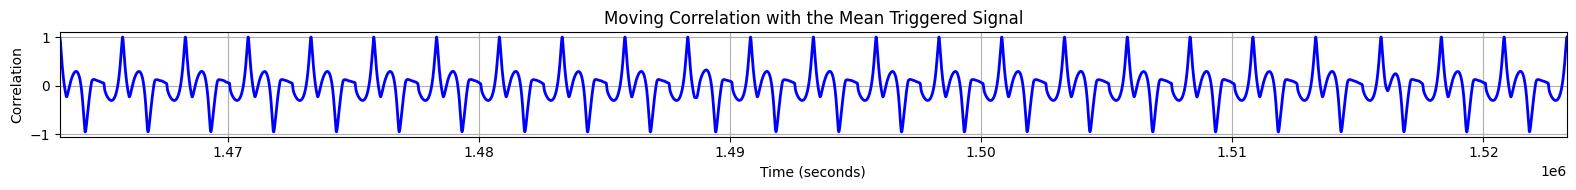

In [9]:
correlations_np = np.array(correlations)
max_correlation_index = np.argmax(correlations_np)

show_index_from = max_correlation_index-len(mean_triggered) * 30
show_index_to = max_correlation_index+len(mean_triggered) * 30
show_correlations = correlations_np[show_index_from:show_index_to]
time_axis = np.linspace(show_index_from, show_index_to, len(show_correlations))

plt.figure(figsize=(16, 2))
plt.plot(time_axis, show_correlations, color='blue', linewidth=2)
plt.xlim(time_axis[0], time_axis[-1])
plt.title('Moving Correlation with the Mean Triggered Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

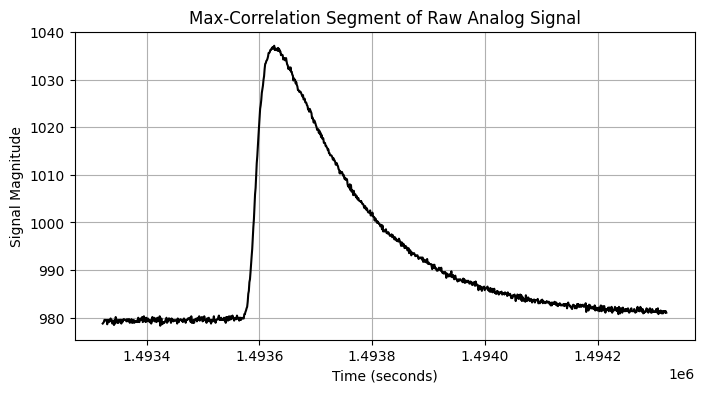

In [10]:
plt.figure(figsize=(8, 4))
index_from = max_correlation_index
index_to = max_correlation_index+len(mean_triggered)
time_axis = np.linspace(index_from, index_to, len(raw_analog_signal[index_from:index_to]))
plt.plot(time_axis, raw_analog_signal[index_from:index_to], color='black')
plt.title('Max-Correlation Segment of Raw Analog Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Magnitude')
plt.grid(True)
plt.show()

In [11]:
n_extract_triggers = len(raw_analog_signal)//(3*len(mean_triggered)//2) # Maximum number of triggers that can be extracted
max_correlations = []
max_correlation_indices = []
for i in range(n_extract_triggers):
    max_correlation_index = np.argmax(correlations_np)
    max_correlation = correlations_np[max_correlation_index]
    max_correlations.append(max_correlation)
    max_correlation_indices.append(max_correlation_index)
    correlations_np[max_correlation_index-len(mean_triggered)//2:max_correlation_index+len(mean_triggered)] = -1

In [12]:
correlation_threshold = 0.8
above_threshold = np.where(np.array(max_correlations) > correlation_threshold)[0]
above_threshold_indices = np.array(max_correlation_indices)[above_threshold]

triggers_indices = above_threshold_indices + abs(kernel_start_sample)
triggers_indices = np.sort(triggers_indices)
n_triggers = len(triggers_indices)
print("Number of triggers detected:", n_triggers)

Number of triggers detected: 1921


In [14]:
np.save('triggers_DET36A2.npy', triggers_indices)
triggers_indices

array([  88789,  143889,  146289, ..., 4936032, 4938532, 4941032])